# Modify the configure_optimizers() behavior of NeuralForecast models
> Tutorial on how to achieve a full control of the `configure_optimizers()` behavior of NeuralForecast models

NeuralForecast models allow us to customize the default optimizer and learning rate scheduler behaviors via 
`optimizer`, `optimizer_kwargs`, `lr_scheduler`, `lr_scheduler_kwargs`. However this is not sufficient to support the use of [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html), for instance, as it requires the specification of `monitor` parameter.

This tutorial provides an example of how to support the use of `ReduceLROnPlateau`. 

## Load libraries

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.utils import AirPassengersPanel

from utilsforecast.plotting import plot_series

/root/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-25 15:57:21,708	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-02-25 15:57:21,760	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Data

We use the AirPassengers dataset for the demonstration of conformal prediction.


In [ ]:
AirPassengersPanel_train = AirPassengersPanel[AirPassengersPanel['ds'] < AirPassengersPanel['ds'].values[-12]].reset_index(drop=True)
AirPassengersPanel_test = AirPassengersPanel[AirPassengersPanel['ds'] >= AirPassengersPanel['ds'].values[-12]].reset_index(drop=True)
AirPassengersPanel_test['y'] = np.nan
AirPassengersPanel_test['y_[lag12]'] = np.nan

## Model training

We now train a NHITS model on the above dataset. We consider two different predictions:
1. Training using the default `configure_optimizers()`.
2. Training by overwriting the `configure_optimizers()` of the subclass of NHITS model.


In [ ]:
horizon = 12
input_size = 24

class CustomNHITS(NHITS):
    def configure_optimizers(self):
        optimizer = torch.optim.Adadelta(params=self.parameters(), rho=0.75)
        scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer, mode='min',factor=0.5, patience=2,
        )
        scheduler_config = {
            'scheduler': scheduler,
            'interval': 'step',
            'frequency': 1,
            'monitor': 'train_loss',
            'strict': True,
            'name': None,
        }
        return {'optimizer': optimizer, 'lr_scheduler': scheduler_config}

models = [
    NHITS(h=horizon, input_size=input_size, max_steps=100, alias='NHITS-default-scheduler'),
    CustomNHITS(h=horizon, input_size=input_size, max_steps=100, alias='NHITS-ReduceLROnPlateau-scheduler'),
]
nf = NeuralForecast(models=models, freq='ME')
nf.fit(AirPassengersPanel_train)
preds = nf.predict(futr_df=AirPassengersPanel_test)

Seed set to 1
Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.751     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, v_num=85, train_loss_step=14.20, train_loss_epoch=14.20]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, v_num=85, train_loss_step=14.20, train_loss_epoch=14.20]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.751     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode



Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s, v_num=86, train_loss_step=24.10, train_loss_epoch=24.10]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s, v_num=86, train_loss_step=24.10, train_loss_epoch=24.10]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.39it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 246.29it/s]


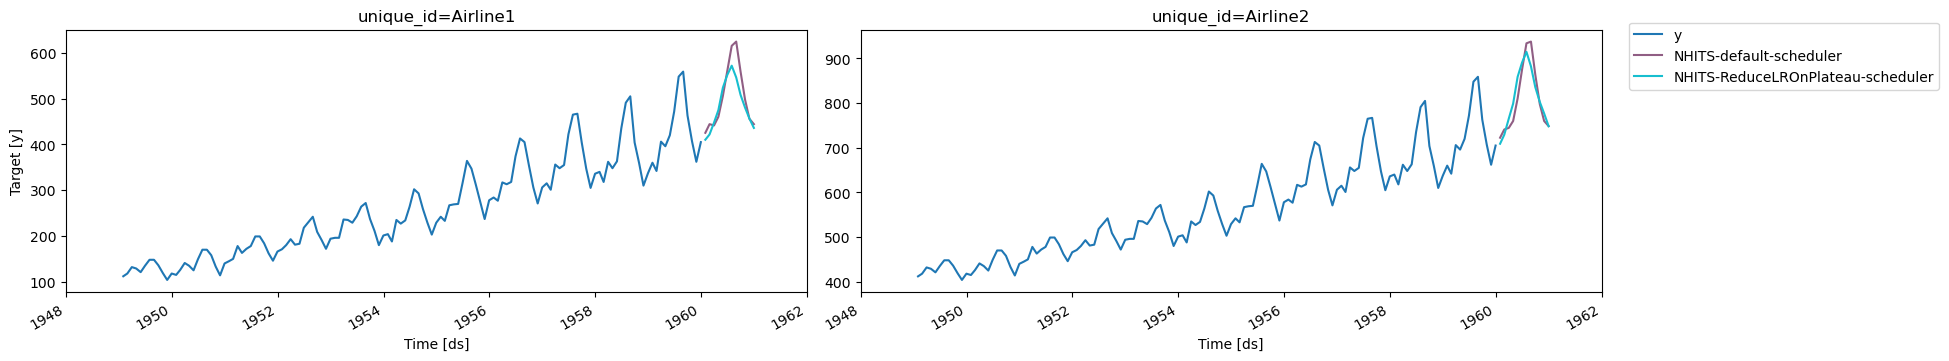

In [ ]:
plot_series(AirPassengersPanel_train, preds)

We can clearly notice the prediction outputs are different due to the change in `configure_optimizers()`.